In [1]:
import numpy as np
import scipy as sp
import pylab as pl
pl.rcParams['figure.figsize'] = 4,4

In [2]:
from GMMBase import *

In [3]:
lamb = 0.5
xmax = 4/lamb
n_sample = int(1e4)
n_clusters = 3
epochs = 1000

In [4]:
x = np.random.RandomState(0).exponential(1./lamb, n_sample)

In [5]:
def Gaussian_pdf(ex):
    return np.exp(- 0.5*(ex-x.mean())**2/x.std()**2
                  - 0.5*np.log(2*np.pi*x.std()**2))

(-0.4191023651728891, 8.0)

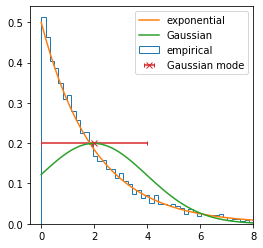

In [6]:
ex = np.linspace(0, xmax)
pl.hist(x, ex, density=True, fill=False, histtype='step',
        label='empirical');
pl.plot(ex, lamb*np.exp(-lamb*ex), label='exponential')

pl.plot(ex, Gaussian_pdf(ex), label='Gaussian')
pl.errorbar([x.mean()], Gaussian_pdf([x.mean()]), None, [x.std()],
            'x', capsize=2, label='Gaussian mode')

pl.legend(loc='upper right')
pl.xlim(xmax=xmax)

# EM

In [7]:
model = GMMModel(n_clusters, 1)
model.initialize()
trainer = GMMTrainer(model)

for epoch in range(100):
    trainer(x[:,None])
    print(epoch, model(mx.nd.array(x[:,None]))[0].mean().asscalar())

0 -2.1108122
1 -2.0933855
2 -2.030236
3 -1.958311
4 -1.9110826
5 -1.8846871
6 -1.870622
7 -1.8632047
8 -1.8591893
9 -1.8568033
10 -1.8550245
11 -1.853128
12 -1.8504231
13 -1.8461436
14 -1.8395956
15 -1.830649
16 -1.8202094
17 -1.8099227
18 -1.8012184
19 -1.794705
20 -1.7902569
21 -1.7873921
22 -1.785592
23 -1.784451
24 -1.7837045
25 -1.7831953
26 -1.7828345
27 -1.7825714
28 -1.7823758
29 -1.7822285
30 -1.7821168
31 -1.7820319
32 -1.7819668
33 -1.7819172
34 -1.7818791
35 -1.78185
36 -1.7818277
37 -1.7818104
38 -1.7817973
39 -1.7817872
40 -1.7817793
41 -1.7817732
42 -1.7817688
43 -1.7817652
44 -1.7817625
45 -1.7817603
46 -1.7817585
47 -1.7817575
48 -1.7817564
49 -1.7817558
50 -1.7817553
51 -1.7817547
52 -1.7817545
53 -1.7817541
54 -1.7817539
55 -1.7817539
56 -1.7817537
57 -1.7817535
58 -1.7817535
59 -1.7817535
60 -1.7817533
61 -1.7817533
62 -1.7817533
63 -1.7817533
64 -1.7817533
65 -1.7817533
66 -1.7817533
67 -1.7817533
68 -1.7817533
69 -1.7817533
70 -1.7817533
71 -1.7817533
72 -1.781753

In [8]:
mu_ = model.mu_.data().asnumpy()
kR_ = model.kR_.data().asnumpy()
cov_ = np.linalg.inv(kR_.swapaxes(1,2) @ kR_)
s2_ = np.array([np.diag(c) for c in cov_])

In [9]:
def mixture_pdf(ex):
    model = GMMModel(n_clusters, 1, mu_, kR_)
    model.initialize()
    log_marg = model(mx.nd.array(ex, dtype='float32'))[0]
    return log_marg.exp().asnumpy()

(-0.4, 8.0)

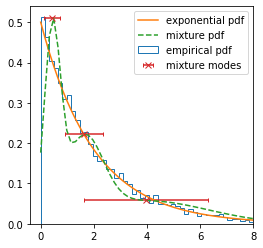

In [10]:
ex = np.linspace(0, xmax)
pl.hist(x, ex, density=True, fill=False, histtype='step',
        label='empirical pdf')
pl.plot(ex, lamb*np.exp(-lamb*ex), label='exponential pdf')

pl.plot(ex, mixture_pdf(ex[:,None]), '--', label='mixture pdf')
pl.errorbar(mu_.squeeze(-1), mixture_pdf(mu_),
            None, s2_.squeeze(-1)**0.5,
            'x', capsize=2, label='mixture modes')

pl.legend(loc='upper right')
pl.xlim(xmax=xmax)